In [302]:
import pandas
import optuna
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

**Загрузка данных**

In [303]:
df = pandas.read_csv("Medicalpremium.csv")
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


In [304]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
Age,1.000000,0.210908,0.244888,-0.008549,0.051072,0.039879,-0.018590,-0.024416,-0.027623,0.429181,0.697540
Diabetes,0.210908,1.000000,0.127727,-0.036652,-0.089428,-0.003783,-0.024563,-0.080102,-0.055527,0.122722,0.076209
BloodPressureProblems,0.244888,0.127727,1.000000,-0.024538,0.045424,-0.037926,-0.061016,-0.011550,0.048239,0.251568,0.167097
AnyTransplants,-0.008549,-0.036652,-0.024538,1.000000,0.035285,-0.031543,0.002087,0.001876,-0.020171,-0.004154,0.289056
AnyChronicDiseases,0.051072,-0.089428,0.045424,0.035285,1.000000,0.047419,-0.033318,-0.027418,0.008666,0.014835,0.208610
Height,0.039879,-0.003783,-0.037926,-0.031543,0.047419,1.000000,0.066946,-0.010200,0.010549,0.037289,0.026910
Weight,-0.018590,-0.024563,-0.061016,0.002087,-0.033318,0.066946,1.000000,0.037492,0.003481,-0.006108,0.141507
KnownAllergies,-0.024416,-0.080102,-0.011550,0.001876,-0.027418,-0.010200,0.037492,1.000000,0.115383,0.103923,0.012103
HistoryOfCancerInFamily,-0.027623,-0.055527,0.048239,-0.020171,0.008666,0.010549,0.003481,0.115383,1.000000,0.212657,0.083139
NumberOfMajorSurgeries,0.429181,0.122722,0.251568,-0.004154,0.014835,0.037289,-0.006108,0.103923,0.212657,1.000000,0.264250


**Выбор признаков**

In [305]:
feature_cols = ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']
x = df[feature_cols]
y = df['PremiumPrice']

In [306]:
x

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries
0,45,0,0,0,0,155,57,0,0,0
1,60,1,0,0,0,180,73,0,0,0
2,36,1,1,0,0,158,59,0,0,1
3,52,1,1,0,1,183,93,0,0,2
4,38,0,0,0,1,166,88,0,0,1
...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0
982,64,1,1,0,0,153,70,0,0,3
983,56,0,1,0,0,155,71,0,0,1
984,47,1,1,0,0,158,73,1,0,1


In [307]:
y

0      25000
1      29000
2      23000
3      28000
4      23000
       ...  
981    15000
982    28000
983    29000
984    39000
985    15000
Name: PremiumPrice, Length: 986, dtype: int64

**Разделение данных на обучающую и тестовую выборки**

In [308]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

**Обучение моделей**

In [309]:
model_LR = LinearRegression()
model_LR.fit(x_train, y_train)

model_tree = DecisionTreeRegressor(max_depth=4)
model_tree.fit(x_train, y_train)

model_cb = CatBoostRegressor(verbose=False)
model_cb.fit(x_train, y_train)

**Добавление подбора гиперпараметров с помощью Optuna**

In [310]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    }
    
    model = CatBoostRegressor(**param)
    
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=0, early_stopping_rounds=100)
    
    preds = model.predict(x_test)
    
    return metrics.mean_squared_error(y_test, preds)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-12-13 03:10:38,523] A new study created in memory with name: no-name-6c25ba3b-d994-4488-b35f-6bfb0cbe38b2
C:\Users\steepday\AppData\Local\Temp\ipykernel_7732\1905136038.py:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

C:\Users\steepday\AppData\Local\Temp\ipykernel_7732\1905136038.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2023-12-13 03:10:38,717] Trial 0 finished with value: 10177759.615814833 and parameters: {'iterations': 145, 'depth': 9, 'learning_rate': 0.09530643572229577, 'random_strength': 55, 'bagging_temperature': 0.7066437666550861}. Best is trial 0 with value: 10177759.615814833.
C:\Users\steepday\AppData\Local\Temp\ipykernel_7732\1905136038.py:5: Future

In [311]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 100
Best trial: {'iterations': 176, 'depth': 4, 'learning_rate': 0.04776543612571375, 'random_strength': 0, 'bagging_temperature': 1.2537869466711755}


**Визуализация результатов оптимизации**

In [312]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_contour(study, params=["depth", "learning_rate"]).show()

**Обучение модели с оптимальными параметрами**

In [313]:
model_cb_optuned = CatBoostRegressor(**study.best_params, verbose=False)
model_cb_optuned.fit(x_train, y_train)

**Предсказание с оптимизированной моделью**

In [314]:
y_pred_cb_optuned = model_cb_optuned.predict(x_test)

**Предсказание**

In [315]:
y_pred_LR = model_LR.predict(x_test)
y_pred_tree = model_tree.predict(x_test)
y_pred_cb = model_cb.predict(x_test)

**Сравнение моделей**

In [316]:
print("Linear Regression MSE: ", metrics.mean_squared_error(y_test, y_pred_LR))
print("Decision Tree MSE: ", metrics.mean_squared_error(y_test, y_pred_tree))
print("CatBoost MSE: ", metrics.mean_squared_error(y_test, y_pred_cb))
print("Optimized CatBoost MSE: ", metrics.mean_squared_error(y_test, y_pred_cb_optuned))


mse_values = {"Linear Regression": metrics.mean_squared_error(y_test, y_pred_LR),
              "Decision Tree": metrics.mean_squared_error(y_test, y_pred_tree),
              "CatBoost": metrics.mean_squared_error(y_test, y_pred_cb)}

best_model = min(mse_values, key=mse_values.get)

print("Best model is: ", best_model)


Linear Regression MSE:  12845090.225016788
Decision Tree MSE:  10528013.363049336
CatBoost MSE:  9160207.061964663
Optimized CatBoost MSE:  7442793.222591296
Best model is:  CatBoost


**Визуализация дерева решений (если глубина дерева позволяет)**

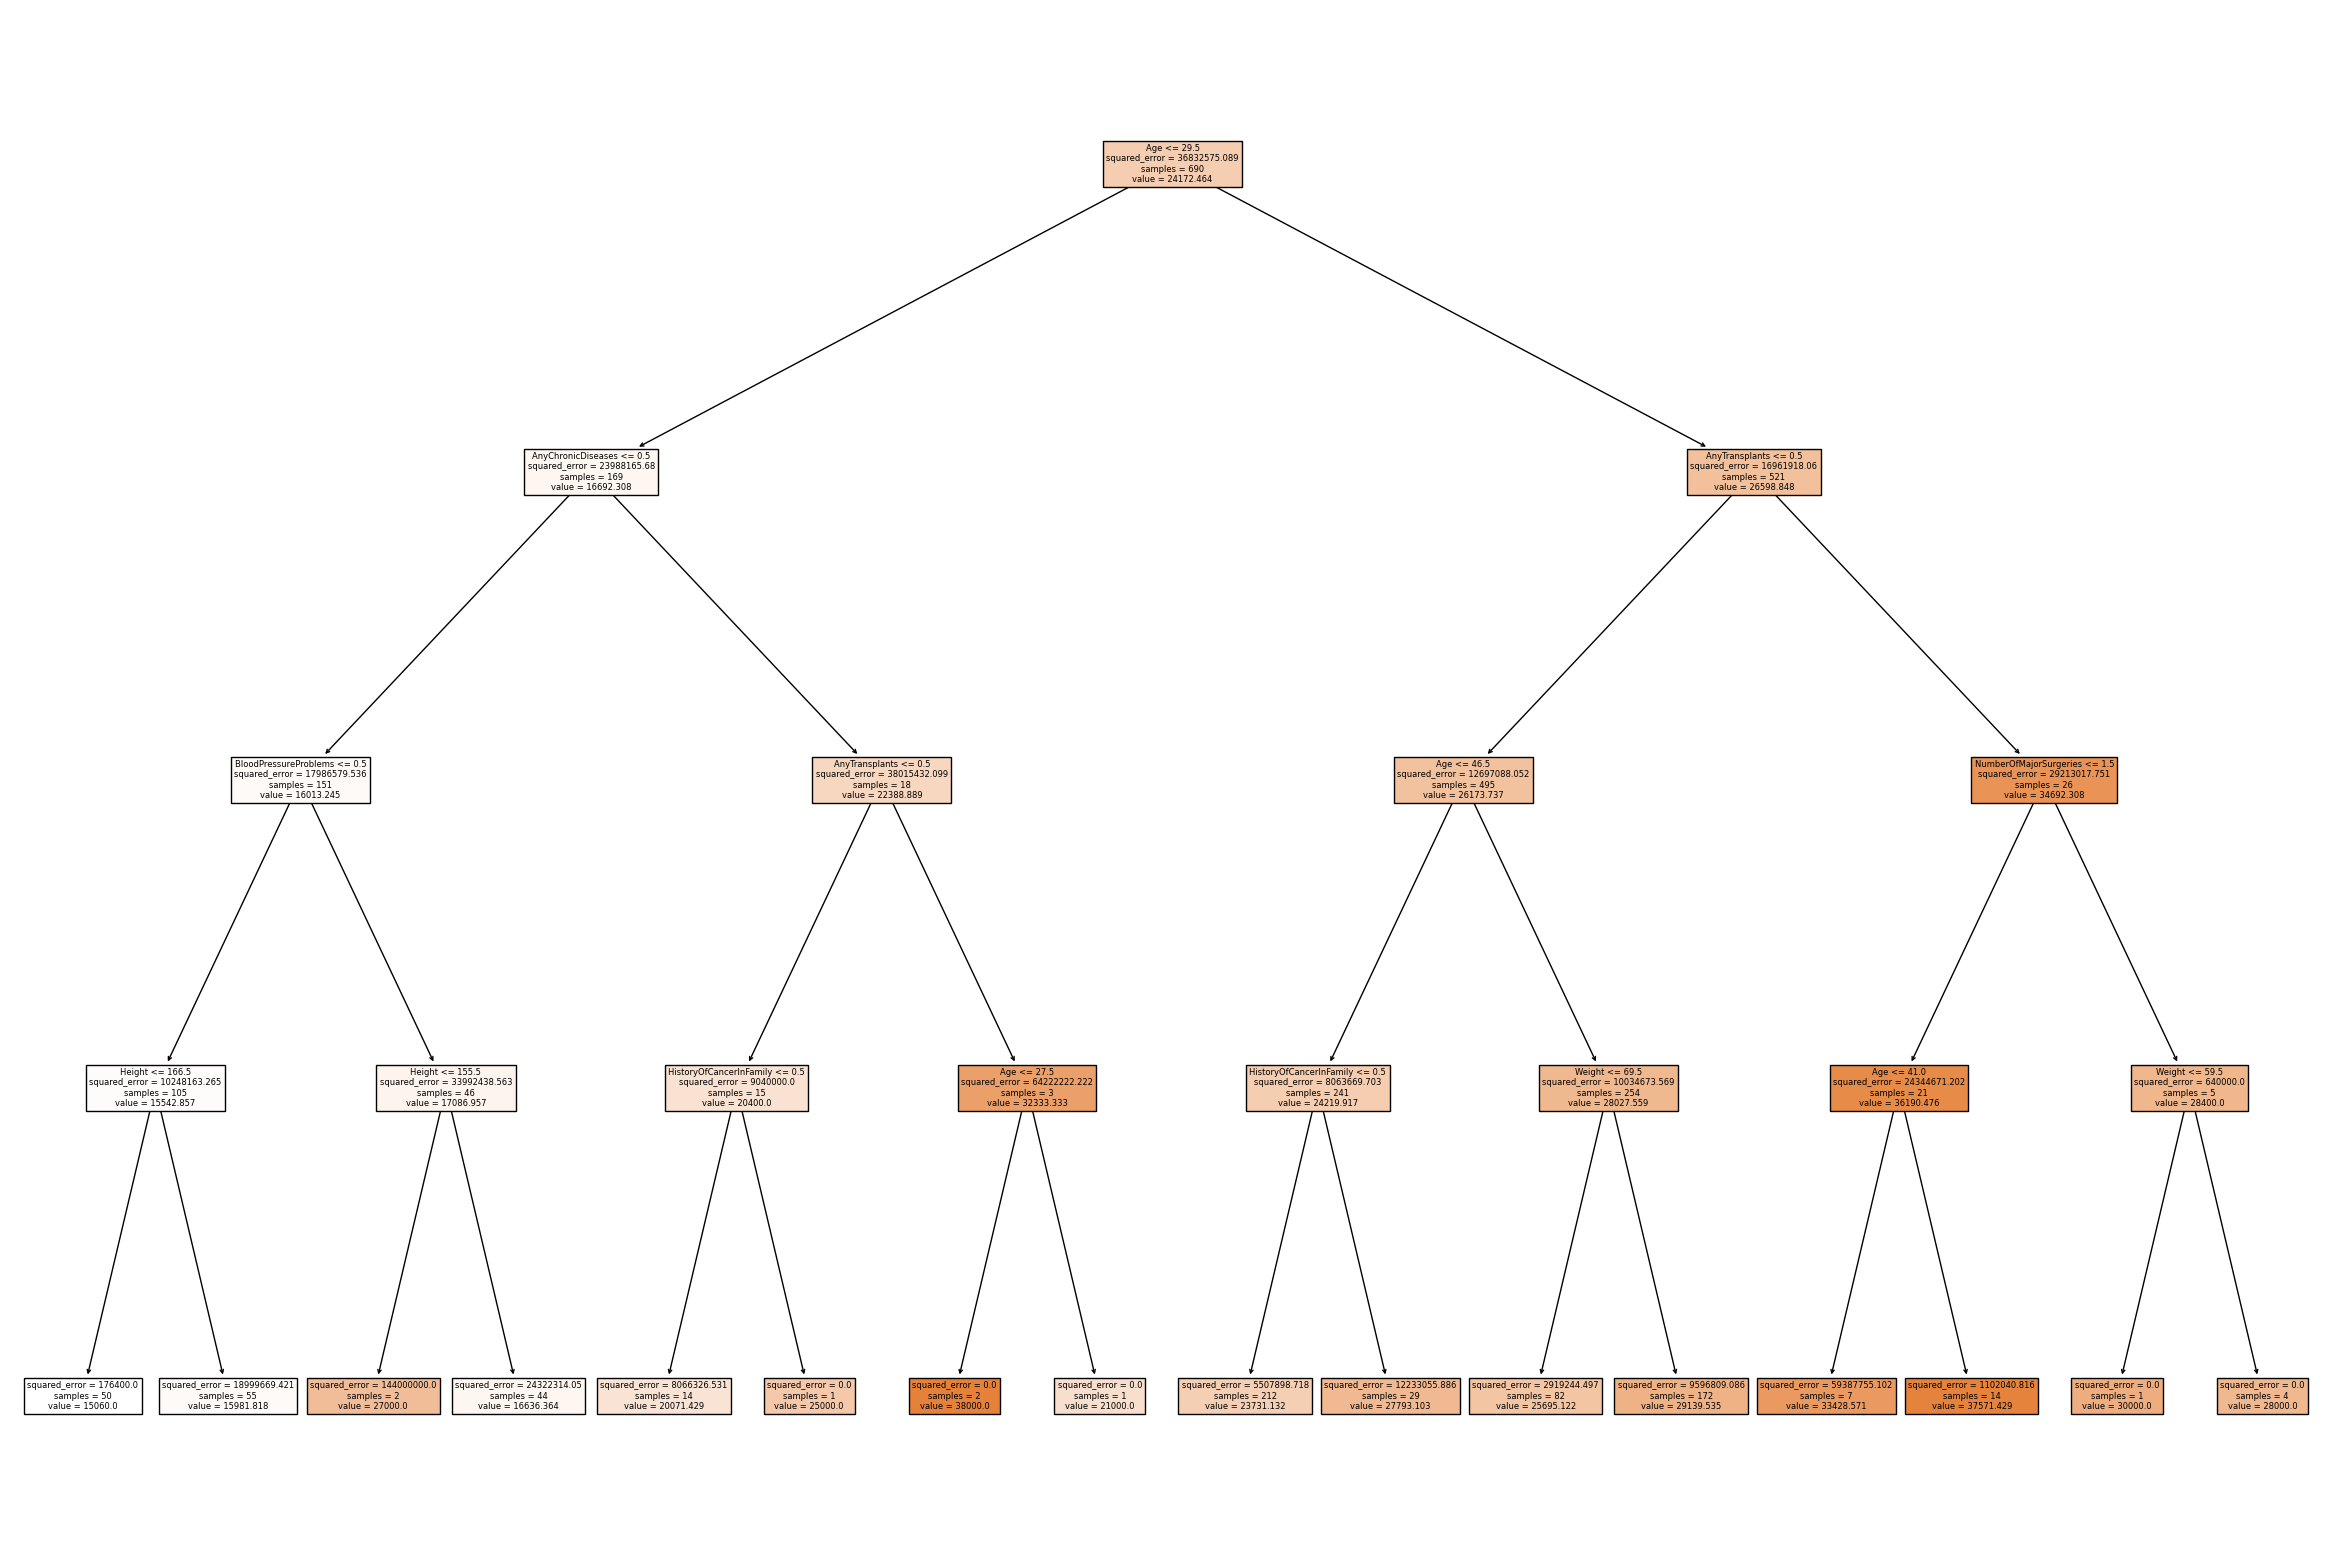

In [317]:
fig = plt.figure(figsize=(30,20))
plot_tree(model_tree, feature_names=feature_cols, filled=True)
plt.show()

**Пример предсказания. На основе новых данных предсказываем сумму страховки**

In [318]:
print("CatBoost prediction: ", model_cb.predict([45, 0, 0, 0, 0, 155, 57, 0, 0, 0]))

CatBoost prediction:  24420.667503055607


**Заключение.**
**В ходе выполнения этого задания было получено множество новых навыков и знаний. В частности, были изучены и применены различные методы машинного обучения, включая линейную регрессию, дерево решений и CatBoost. Был также использован метод подбора гиперпараметров с помощью Optuna, что позволило улучшить точность модели.**

**Оптимизированный метод CatBoost оказался точнее обычного.**

**Однако, несмотря на все усилия, точность модели может оставаться недостаточной для некоторых приложений. Это может быть связано с различными факторами, такими как сложность данных, выбор признаков или ограничения моделей машинного обучения.**

**Полученные результаты могут быть использованы в различных областях. Например, они могут помочь страховым компаниям в прогнозировании стоимости страховых полисов на основе характеристик клиентов. Они также могут быть использованы в научных исследованиях для изучения влияния различных факторов на стоимость медицинской страховки.**